# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [0]:
%matplotlib inline
import os
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import cv2
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1234)

(112, 92)


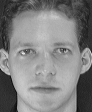

In [4]:
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/drive/My Drive/Siamese/data/faces/training/s1/1.pgm')
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(img.shape)
cv2_imshow(img)

## Helper functions
Set of helper functions

In [0]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

## Configuration Class
A simple class to manage configuration

In [0]:
class Config():
    training_dir = "/content/drive/My Drive/Siamese/data/faces/training/"
    testing_dir = "/content/drive/My Drive/Siamese/data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 25

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]])

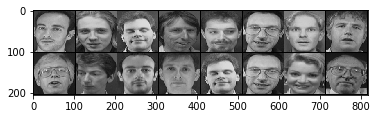

In [10]:
trainloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)


batch = next(iter(trainloader))
concatenated = torch.cat((batch[0],batch[1]),0)
show_batch(concatenated)
batch[2]

## Neural Net Definition
We will use a standard convolutional neural network

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [16]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

Epoch number 0
 Current loss 2.016836643218994

Epoch number 1
 Current loss 1.3647487163543701

Epoch number 2
 Current loss 0.8509489893913269

Epoch number 3
 Current loss 0.5333439111709595

Epoch number 4
 Current loss 0.36331766843795776

Epoch number 5
 Current loss 0.39618924260139465

Epoch number 6
 Current loss 0.394560307264328

Epoch number 7
 Current loss 0.2957059144973755

Epoch number 8
 Current loss 0.2922403812408447

Epoch number 9
 Current loss 0.2510144114494324

Epoch number 10
 Current loss 0.19395793974399567

Epoch number 11
 Current loss 0.27345865964889526

Epoch number 12
 Current loss 0.1881740689277649

Epoch number 13
 Current loss 0.11677564680576324

Epoch number 14
 Current loss 0.09638557583093643

Epoch number 15
 Current loss 0.14260229468345642

Epoch number 16
 Current loss 0.09282007813453674

Epoch number 17
 Current loss 0.09553766995668411

Epoch number 18
 Current loss 0.07243746519088745

Epoch number 19
 Current loss 0.08181662857532501

E

In [0]:
torch.save(net.state_dict(), "/content/drive/My Drive/Siamese/data/faces/testing/model.pt")

## Testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [0]:
#Download Face evolve model files 

#Getting files require to run Face Evolve model based on MTCNN for Face Detection 

!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/align_trans.py -O ./align_trans.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/box_utils.py -O ./box_utils.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/detector.py -O ./detector.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/face_align.py -O ./face_align.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/face_resize.py -O ./face_resize.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/first_stage.py -O ./first_stage.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/get_nets.py -O ./get_nets.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/matlab_cp2tform.py -O ./matlab.cpt2tform.py
  
#Getting the weights of three models Onet, Pnet and Rnet 
!wget https://github.com/ZhaoJ9014/face.evoLVe.PyTorch/raw/master/align/onet.npy -O ./onet.npy
!wget https://github.com/ZhaoJ9014/face.evoLVe.PyTorch/raw/master/align/pnet.npy -O ./pnet.npy
!wget https://github.com/ZhaoJ9014/face.evoLVe.PyTorch/raw/master/align/rnet.npy -O ./rnet.npy
  
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/visualization_utils.py -O ./visualization_utils.py

In [0]:
from detector import detect_faces

In [0]:
def face_detection(image):
  bounding_box = detect_faces(image)
  cropped_image = image.crop((bounding_box[0][0],bounding_box[0][1],bounding_box[0][2],bounding_box[0][3]))
  return cropped_image

In [0]:
def face_comparison(image_path1, image_path2):
  img = Image.open(image_path1)
  first_image = img.resize((255,255), Image.ANTIALIAS) 
  bounding_box = detect_faces(first_image)
  first_image = first_image.crop((bounding_box[0][0][0],bounding_box[0][0][1],bounding_box[0][0][2],bounding_box[0][0][3]))
  first_image = first_image.convert('L')
  t = transforms.ToTensor()
  first_tensor = t(first_image.resize((100,100)))
  first = first_tensor.unsqueeze(0)
  #for the second image
  img2 = Image.open(image_path2)
  second_image = img2.resize((255,255), Image.ANTIALIAS) 
  bounding_box = detect_faces(second_image)
  second_image = second_image.crop((bounding_box[0][0][0],bounding_box[0][0][1],bounding_box[0][0][2],bounding_box[0][0][3]))
  second_image = second_image.convert('L')
  t = transforms.ToTensor()
  second_tensor = t(second_image.resize((100,100)))
  second = second_tensor.unsqueeze(0)
  
  
  concatenated = torch.cat((first,second),0)

  output1,output2 = net(Variable(first).cuda(),Variable(second).cuda())
  euclidean_distance = F.pairwise_distance(output1, output2)
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
  

In [34]:
img = Image.open('/content/drive/My Drive/Siamese/data/faces/testing/yo.jpeg')
first_image = img.resize((255,255), Image.ANTIALIAS)
bounding_box = detect_faces(first_image)
first_image = first_image.crop((bounding_box[0][0][0],bounding_box[0][0][1],bounding_box[0][0][2],bounding_box[0][0][3]))
first_image = first_image.convert('L')
t = transforms.ToTensor()
first_tensor = t(first_image.resize((100,100)))
first = first_tensor.unsqueeze(0)

/content/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile = True)
/content/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/content/detector.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile = True)
/content/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/content/detector.py:100: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile = True)
/content/get_nets.py:168: UserWarning: Implicit dimension choice for softmax has been deprecated.

In [35]:
first.shape

torch.Size([1, 1, 100, 100])

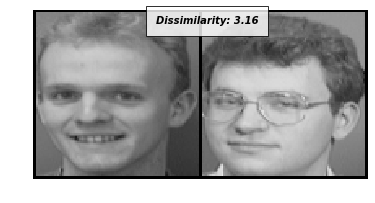

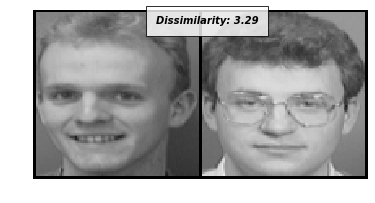

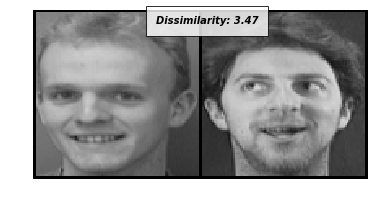

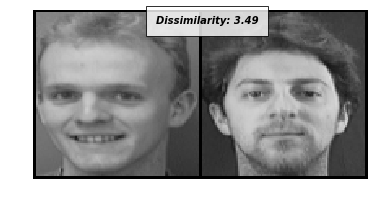

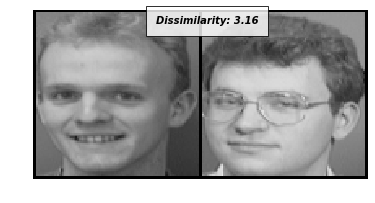

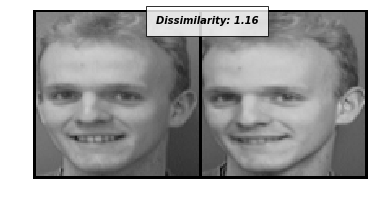

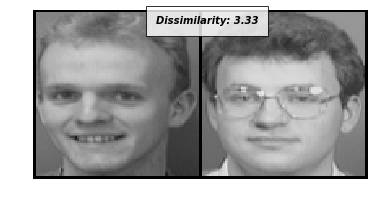

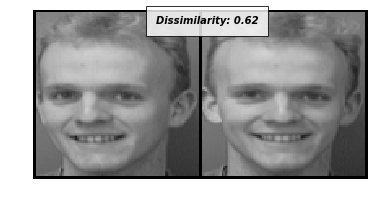

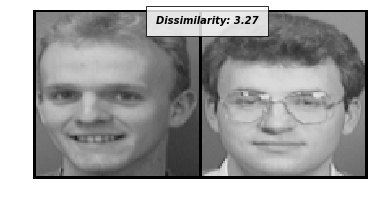

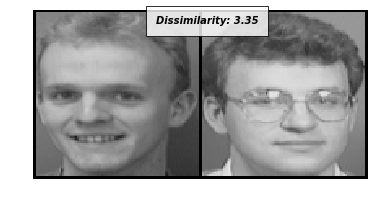

In [37]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))


/content/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile = True)
/content/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/content/detector.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile = True)
/content/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/content/detector.py:100: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile = True)
/content/get_nets.py:168: UserWarning: Implicit dimension choice for softmax has been deprecated.

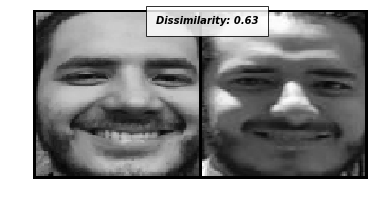

In [38]:
#sanity check on different images that are not in the test set
face_comparison('/content/drive/My Drive/Siamese/data/faces/testing/yo.jpeg', '/content/drive/My Drive/Siamese/data/faces/testing/yo2.jpg')